# Thermodynamics of Tumorspheres


## 1. Mean Area of a Cell in an n-Cluster

In [1]:
import pandas as pd
import numpy as np

df_original = pd.read_csv('df_area_clusters.csv')

df = df_original.copy()

# Per-cell area for each observation
df["a_cell"] = df["area"] / df["n"]

# Aggregate by cluster size n
summary = (
    df
    .groupby("n")
    .agg(
        a_mean=("a_cell", "mean"),
        a_std=("a_cell", "std"),
        count=("a_cell", "size"),
    )
    .reset_index()
)

# Standard error of the mean
summary["a_sem"] = summary["a_std"] / np.sqrt(summary["count"])

print(summary)


   n      a_mean      a_std  count      a_sem
0  1  435.428571  88.311138     21  19.271070
1  2  378.333333  60.137587     18  14.174565
2  3  358.636364  68.756214     22  14.658874
3  4  340.812500  59.464157     20  13.296590


In [4]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

# --- Estimate a0 from n=1 per-cell area (your definition) ---
a0 = summary.loc[summary["n"] == 1, "a_mean"].iloc[0]

df_fit = df.copy()

# A0(n) = n * a0
df_fit["A0"] = df_fit["n"] * a0

# Define x = L/(2A) and y = ln(A/A0)
df_fit["x"] = df_fit["perimeter"] / (2.0 * df_fit["area"])
df_fit["y"] = np.log(df_fit["area"] / df_fit["A0"])

# Optional: drop any problematic rows (shouldn't happen if inputs are clean)
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(subset=["x", "y"])

# Through-origin linear fit: y = m x
X = df_fit[["x"]].to_numpy()
y = df_fit["y"].to_numpy()

lin = LinearRegression(fit_intercept=False)
lin.fit(X, y)

m = lin.coef_[0]
tau_over_K = -m

print(f"slope m = {m:.6g}")
print(f"tau/K_2D = {tau_over_K:.6g}")


slope m = -2.23618
tau/K_2D = 2.23618


In [7]:
import statsmodels.api as sm

X = df_fit[["x"]].to_numpy()  # no intercept column -> forces through-origin
y = df_fit["y"].to_numpy()

model = sm.OLS(y, X)          # through origin by construction
res = model.fit()

m = res.params[0]
m_se = res.bse[0]

print(res.summary())
print(f"slope m = {m:.6g} ± {m_se:.6g} (1σ)")
print(f"tau/K_2D = {-m:.6g} ± {m_se:.6g} (1σ)")


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.354
Model:                            OLS   Adj. R-squared (uncentered):              0.346
Method:                 Least Squares   F-statistic:                              43.83
Date:                Mon, 02 Feb 2026   Prob (F-statistic):                    3.76e-09
Time:                        21:51:39   Log-Likelihood:                          11.449
No. Observations:                  81   AIC:                                     -20.90
Df Residuals:                      80   BIC:                                     -18.50
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
print(df.describe())

             img   centroid_x   centroid_y         area   perimeter  \
count  81.000000    81.000000    81.000000    81.000000   81.000000   
mean   61.160494   670.750218   510.424549   909.864198  112.439307   
std    22.652515   422.635300   281.441073   391.110271   27.643300   
min     5.000000    15.353503    18.864315   304.000000   63.112698   
25%    62.000000   353.666960   289.587041   559.000000   85.597980   
50%    64.000000   614.154206   473.256637   884.000000  116.811183   
75%    71.000000  1050.805794   744.435818  1196.000000  130.710678   
max    93.000000  1390.162664  1013.231369  1698.000000  163.053824   

       circularity          n      a_cell  
count    81.000000  81.000000   81.000000  
mean      0.872342   2.506173  378.521605  
std       0.059716   1.130525   78.187560  
min       0.678266   1.000000  225.000000  
25%       0.834035   1.000000  323.000000  
50%       0.869412   3.000000  379.333333  
75%       0.922878   3.000000  423.250000  
max     

In [6]:
summary_L = (
    df
    .groupby("n")
    .agg(
        A_mean=("area", "mean"),
        L_mean=("perimeter", "mean"),
        L_std=("perimeter", "std"),
        count=("perimeter", "size"),
    )
    .reset_index()
)

summary = summary.merge(summary_L, on=["n", "count"])


In [3]:
summary

,n,a_mean,a_std,count,a_sem,A_mean,L_mean,L_std
0,1,435.428571,88.311138,21,19.271070,435.428571,75.582461,7.951800
1,2,378.333333,60.137587,18,14.174565,756.666667,105.699675,9.811812
2,3,358.636364,68.756214,22,14.658874,1075.909091,126.563190,14.324799
3,4,340.812500,59.464157,20,13.296590,1363.250000,141.668395,12.776842


Note to self: `summary` contains the per-cell quantities

$$
a_n = \langle a \rangle_{n}, \qquad
\mathrm{SEM}_n = \frac{\sigma_n}{\sqrt{N_n}}.
$$

where “SEM” means Standard Error of the Mean, and cluster-level quantities $\langle A\rangle_n$ and $\langle L\rangle_n$.

In [11]:
summary

,n,a_mean,a_std,count,a_sem,A_mean,L_mean,L_std
0,1,435.428571,88.311138,21,19.271070,435.428571,75.582461,7.951800
1,2,378.333333,60.137587,18,14.174565,756.666667,105.699675,9.811812
2,3,358.636364,68.756214,22,14.658874,1075.909091,126.563190,14.324799
3,4,340.812500,59.464157,20,13.296590,1363.250000,141.668395,12.776842


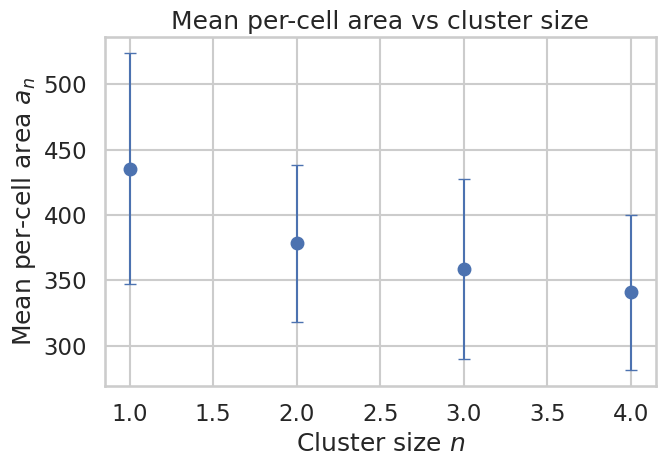

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn styling
sns.set_theme(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(7, 5))

ax.errorbar(
    summary["n"],
    summary["a_mean"],
    yerr=summary["a_std"],
    fmt="o",
    capsize=4,
    lw=1.5,
)

ax.set_xlabel("Cluster size $n$")
ax.set_ylabel(r"Mean per-cell area $a_n$")
ax.set_title("Mean per-cell area vs cluster size")

plt.tight_layout()
plt.show()



In [15]:
import numpy as np
from scipy.optimize import curve_fit

def a_model(n, a_inf, c):
    return a_inf + c / np.sqrt(n)

# Data for fitting
n_vals = summary["n"].values
a_vals = summary["a_mean"].values
a_sem = summary["a_sem"].values

# Initial guesses:
# a_inf ~ smallest observed mean
# c ~ (a(n=1) - a_inf)
a_inf_0 = a_vals.min()
c_0 = a_vals.max() - a_inf_0

popt, pcov = curve_fit(
    a_model,
    n_vals,
    a_vals,
    sigma=a_sem,
    absolute_sigma=True,
    p0=(a_inf_0, c_0),
)

a_inf_hat, c_hat = popt
a_inf_err, c_err = np.sqrt(np.diag(pcov))

print(f"a_inf = {a_inf_hat:.3f} ± {a_inf_err:.3f}")
print(f"c     = {c_hat:.3f} ± {c_err:.3f}")


a_inf = 248.612 ± 30.169
c     = 186.085 ± 44.819


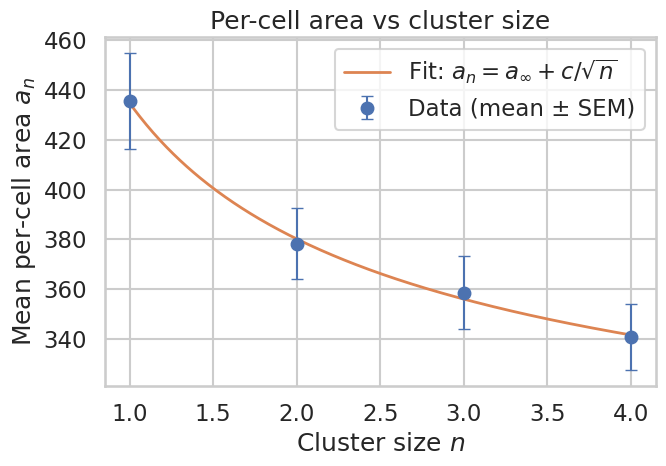

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(7, 5))

# Data with SEM error bars
ax.errorbar(
    summary["n"],
    summary["a_mean"],
    yerr=summary["a_sem"],
    fmt="o",
    capsize=4,
    lw=1.5,
    label="Data (mean ± SEM)",
)

# Smooth n-grid for fitted curve
n_fit = np.linspace(summary["n"].min(), summary["n"].max(), 300)
a_fit = a_model(n_fit, a_inf_hat, c_hat)

ax.plot(
    n_fit,
    a_fit,
    lw=2,
    label=rf"Fit: $a_n = a_\infty + c/\sqrt{{n}}$",
)

ax.set_xlabel("Cluster size $n$")
ax.set_ylabel(r"Mean per-cell area $a_n$")
ax.set_title("Per-cell area vs cluster size")

ax.legend()
plt.tight_layout()
plt.show()
